In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [3]:
#loading dataset
dataframe=pd.read_csv(r"C:\Users\Bogere\OneDrive\Desktop\Research Project\NFLX.csv")
print(dataframe.head())
dataframe.info()
dataframe.columns
dataframe.shape

         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-nu

(1009, 7)

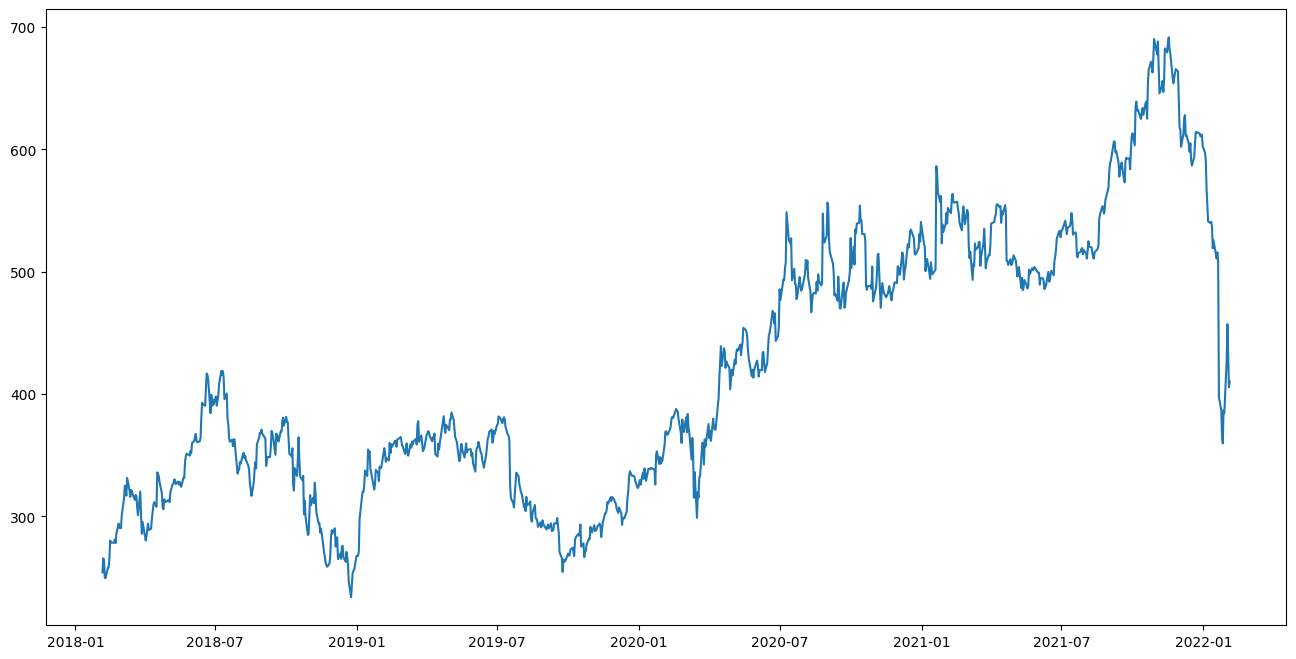

In [4]:
### Analyze the closing prices from dataframe:
dataframe["Date"]=pd.to_datetime(dataframe.Date,format="%Y-%m-%d")
dataframe.index=dataframe['Date']
plt.figure(figsize=(16,8))
plt.plot(dataframe["Close"],label='Close Price history')

In [6]:
###Function for time series analysis
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=5).mean()
    MSTD = timeseries.rolling(window=5).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

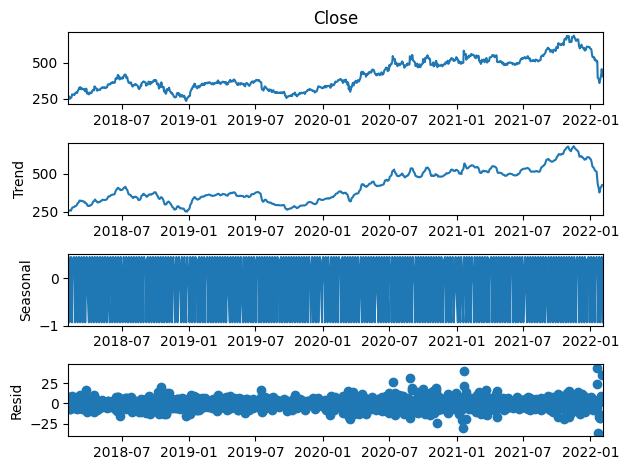

In [8]:
dec = sm.tsa.seasonal_decompose(dataframe['Close'],period = 5, model = 'additive').plot()
plt.show()

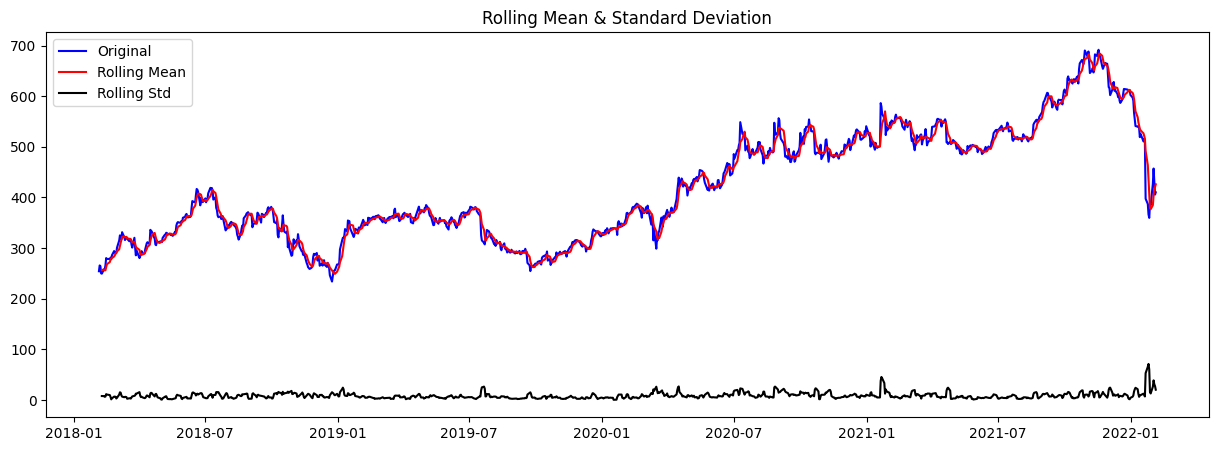

Results of Dickey-Fuller Test:
Test Statistic                   -1.812591
p-value                           0.374229
#Lags Used                        6.000000
Number of Observations Used    1002.000000
Critical Value (1%)              -3.436893
Critical Value (5%)              -2.864429
Critical Value (10%)             -2.568308
dtype: float64


In [9]:
###Stationary test for closing price
test_stationarity(dataframe['Close'] )

d:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


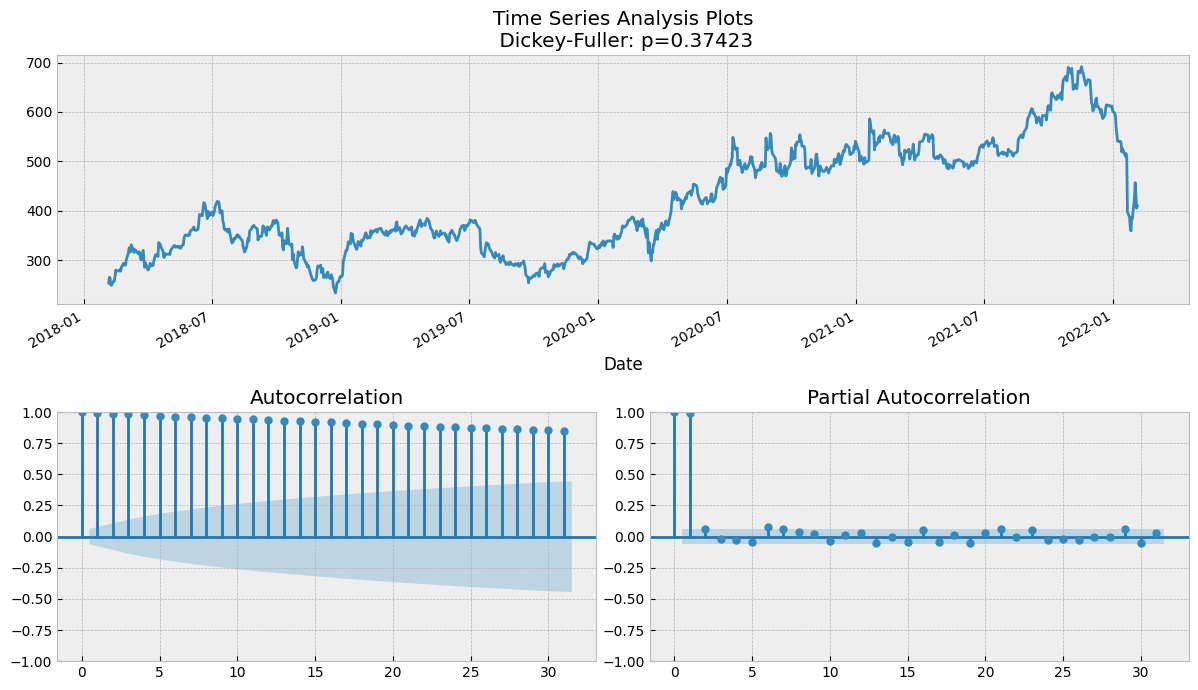

In [11]:
###Duckey Fuller Test of closing price with acf and pacf plot
tsplot(dataframe['Close'])

In [21]:
data_diff = dataframe.diff()
data_diff = data_diff.dropna()

d:\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


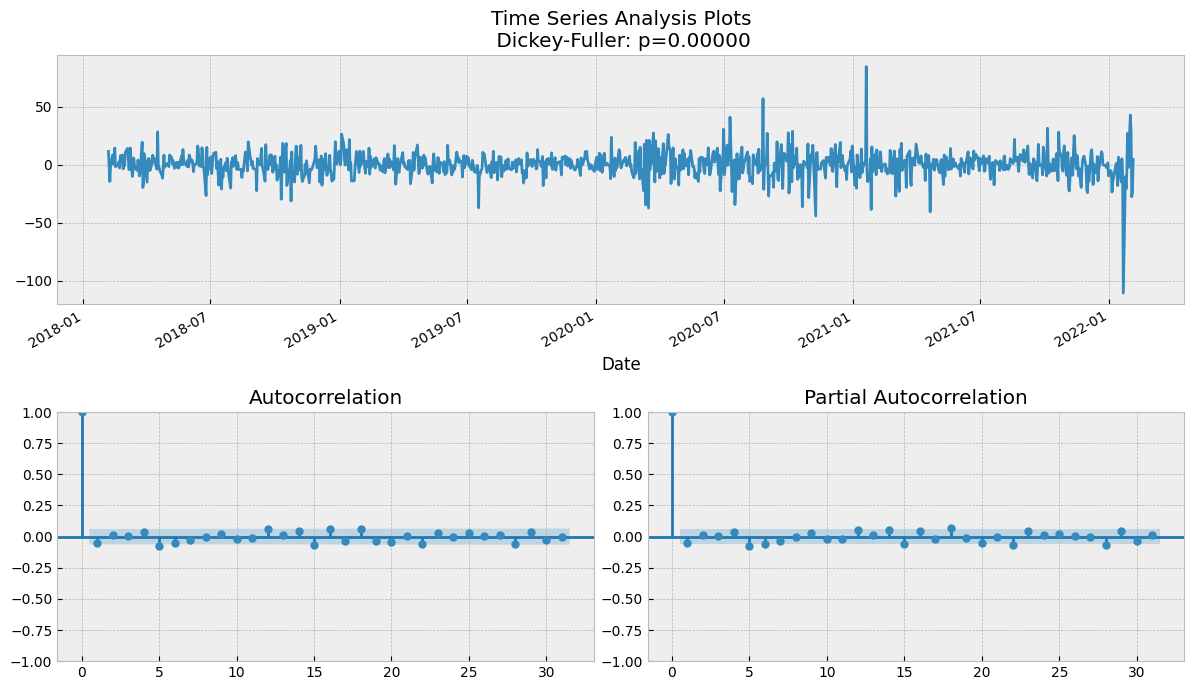

In [12]:
tsplot(data_diff['Close'])

In [13]:
### sort the dataset on date time and filter “Date” and “Close” columns:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
data=dataframe.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(dataframe)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [39]:
###Netflix Friday to Monday Prediction
dataframe['Datetime'] = pd.to_datetime(dataframe['Date'])
dataframe = dataframe.set_index('Datetime')
dataframe

,Date,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2018-02-05,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
2022-01-31,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
2022-02-01,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
2022-02-02,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000


Text(0.5, 0, 'Year')

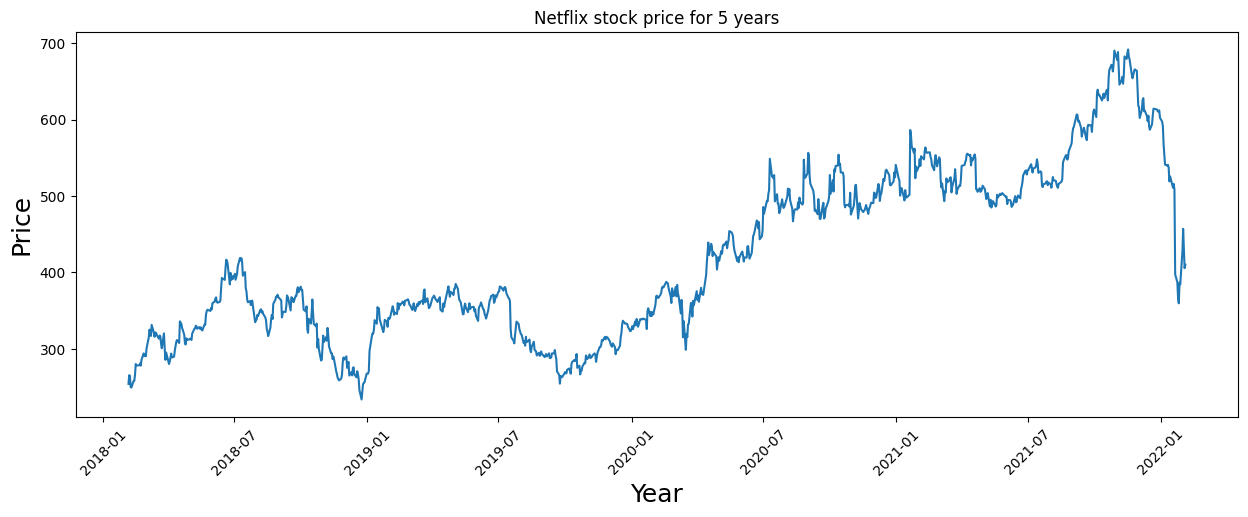

In [40]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation = 45)
plt.plot(dataframe['Adj Close'])
plt.title('Netflix stock price for 5 years')
plt.ylabel('Price', fontsize=18)
plt.xlabel('Year', fontsize=18)

Text(0.5, 0, 'Year')

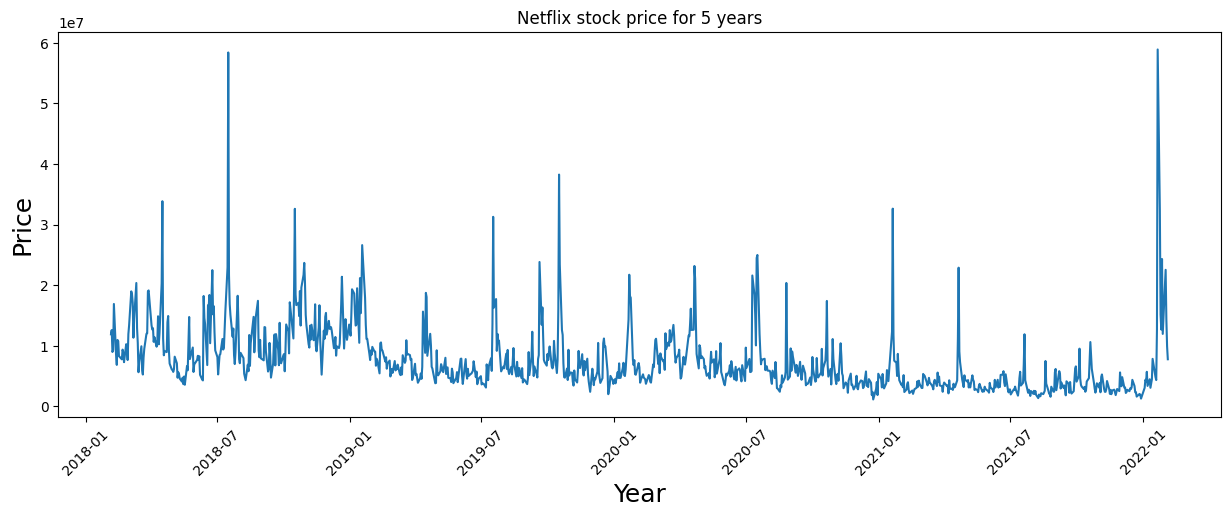

In [41]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation = 45)
plt.plot(dataframe['Volume'])
plt.title('Netflix stock price for 5 years')
plt.ylabel('Price', fontsize=18)
plt.xlabel('Year', fontsize=18)

array([<Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>], dtype=object)

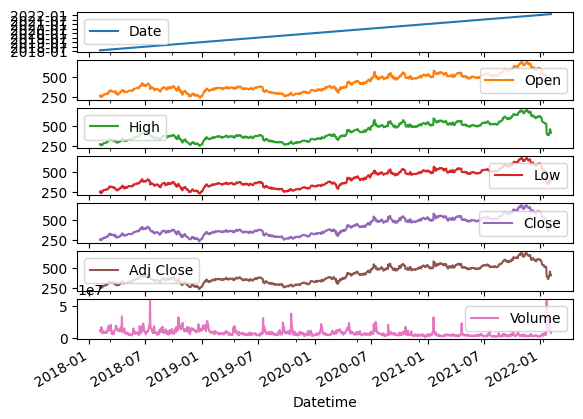

In [42]:
#subplots for different variables against datetime
dataframe.plot(subplots=True)

In [43]:
#finding out whether buying on Friday and selling on Monday is profitable.
#Taking (mon - fri) / fri to get % change,Each of this is 1 data point
##0: Monday, 1: Tues, 2: Wed, 3: Thurs, 4: Fri
dataframe['Day'] = pd.to_datetime(dataframe['Date']).dt.weekday
dataframe

,Date,Open,High,Low,Close,Adj Close,Volume,Day
Datetime,,,,,,,,
2018-02-05,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,0
2018-02-06,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,1
2018-02-07,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,2
2018-02-08,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,3
2018-02-09,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,4
...,...,...,...,...,...,...,...,...
2022-01-31,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500,0
2022-02-01,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300,1
2022-02-02,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000,2


In [44]:
#filtering mondays and fridays
filter_df = dataframe[(dataframe['Day'] == 0) | (dataframe['Day'] == 4)]
filter_df = filter_df.sort_values('Date').reset_index(drop=True)
filter_df['DateTime'] = pd.to_datetime(filter_df['Date'])
filter_df['diff_days'] = filter_df['DateTime'].diff()
filter_df.head(10)
info_df = pd.DataFrame(columns=['buy_date', 'sell_date', 'buy_px', 'sell_px'])
for i in range(len(filter_df)):
    if filter_df.loc[i, 'diff_days'].days == 3:
        info_df = info_df.append(
        {
            'buy_date': filter_df.loc[i-1, 'Date'], 
            'sell_date':filter_df.loc[i, 'Date'], 
            'buy_px':filter_df.loc[i-1, 'Adj Close'], 
            'sell_px':filter_df.loc[i, 'Adj Close']
            
        },ignore_index=True
        )

C:\Users\Bogere\AppData\Local\Temp\ipykernel_8316\59770350.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_df = info_df.append(
C:\Users\Bogere\AppData\Local\Temp\ipykernel_8316\59770350.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_df = info_df.append(
C:\Users\Bogere\AppData\Local\Temp\ipykernel_8316\59770350.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_df = info_df.append(
C:\Users\Bogere\AppData\Local\Temp\ipykernel_8316\59770350.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_df = info_df.append(
C:\Users\Bogere\AppData\Local\Temp\ipykernel_8316\59770350.py:10: FutureWarning: The frame.a

In [45]:
info_df['pct'] =  ((info_df['sell_px'] - info_df['buy_px']) / info_df['buy_px']) *100
#Platform Contribution Transaction

<Axes: ylabel='Frequency'>

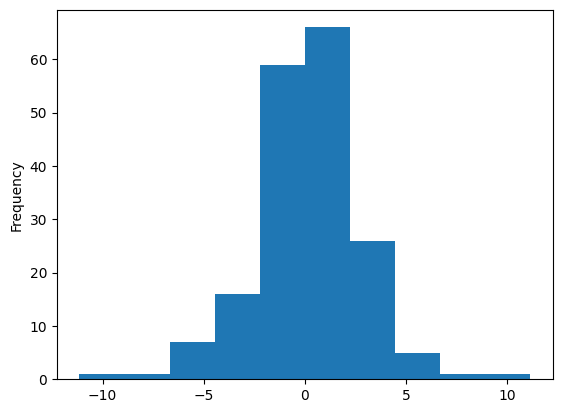

In [46]:
info_df['pct'].plot.hist()

In [49]:
info_df['pct'].describe(percentiles = np.arange(0,1,0.1))
###according to output bellow,On average we will make 0.210645% profit if we buy on Friday close and sell on the subsequent Monday close.
###This is unlikely to be a profitable strategy after transaction cost.

count    183.000000
mean       0.210645
std        2.715924
min      -11.138862
0%       -11.138862
10%       -2.864002
20%       -1.569289
30%       -0.905648
40%       -0.364202
50%        0.248147
60%        1.006677
70%        1.501130
80%        2.086089
90%        3.197125
max       11.130199
Name: pct, dtype: float64

In [23]:
# working with LSTM
# setting target variable, 
###which will be used as the value that will be predicted by the LSTM model, then outputted
output_var = pd.DataFrame(dataframe['Adj Close']) 


In [24]:
features = ['Open', 'High', 'Low', 'Volume']
# independent variables to the target variable above

In [25]:
#Scaling the csv values down to cut down on memory consumption 
scaler = MinMaxScaler()
feature_tf = scaler.fit_transform(dataframe[features])
feature_tf = pd.DataFrame(columns = features, data = feature_tf, index = dataframe.index)
feature_tf.head()

,Open,High,Low,Volume
Date,,,,
2018-02-05,0.061253,0.038304,0.041331,0.186150
2018-02-06,0.030059,0.035640,0.030273,0.198264
2018-02-07,0.071243,0.048408,0.072770,0.135690
2018-02-08,0.072334,0.037683,0.041265,0.141320
2018-02-09,0.043474,0.011436,0.010729,0.272902


In [28]:
#Spliting the csv data into sets for training the model (90% of the data) and testing the model (10% of the data)
timesplit = TimeSeriesSplit(n_splits=10) 
for train_index, test_index in timesplit.split(feature_tf):
        X_train, X_test = feature_tf[:len(train_index)], feature_tf[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [29]:
# processing the data for the LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [30]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1)) 
lstm.compile(loss='mean_absolute_error', optimizer='adam')

In [16]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [35]:
model = lstm.fit( X_train,y_train,epochs =150, batch_size = 8, verbose = 1)
# training the model on 150 epochs

Epoch 1/150
115/115 [==============================] - 5s 4ms/step - loss: 401.3036
Epoch 2/150
115/115 [==============================] - 0s 4ms/step - loss: 400.0056
Epoch 3/150
115/115 [==============================] - 0s 4ms/step - loss: 396.2417
Epoch 4/150
115/115 [==============================] - 0s 4ms/step - loss: 389.0742
Epoch 5/150
115/115 [==============================] - 0s 4ms/step - loss: 378.5610
Epoch 6/150
115/115 [==============================] - 1s 5ms/step - loss: 365.1038
Epoch 7/150
115/115 [==============================] - 1s 6ms/step - loss: 349.1325
Epoch 8/150
115/115 [==============================] - 0s 4ms/step - loss: 330.9580
Epoch 9/150
115/115 [==============================] - 0s 4ms/step - loss: 310.8490
Epoch 10/150
115/115 [==============================] - 0s 4ms/step - loss: 288.9429
Epoch 11/150
115/115 [==============================] - 0s 4ms/step - loss: 265.3818
Epoch 12/150
115/115 [==============================] - 0s 4ms/step - loss

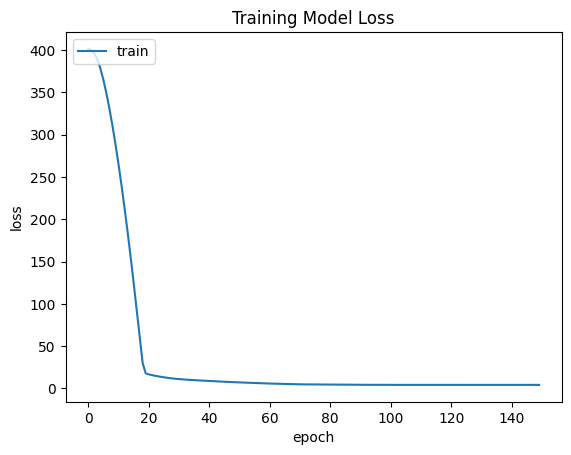

In [36]:
plt.plot(model.history['loss'])
plt.title('Training Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [37]:
#LSTM Prediction
y_pred = lstm.predict(X_train)

29/29 [==============================] - 0s 2ms/step


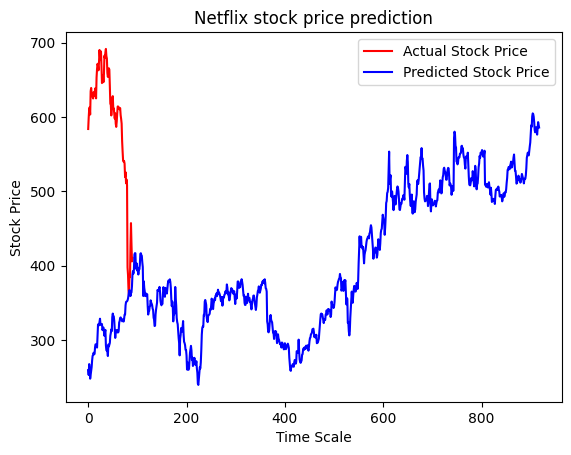

In [38]:
# Comparing the LSTM prediction and the actual value of the Adjusted for Close price via plot
plt.plot(y_test, color='red',label='Actual Stock Price')
plt.plot(y_pred,color='blue', label='Predicted Stock Price')
plt.title("Netflix stock price prediction")
plt.xlabel('Time Scale')
plt.ylabel('Stock Price')
plt.legend()
plt.show()